In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# !unzip 'cityscapes_data.zip'

## DATA

In [4]:
train_fns = os.listdir(os.path.join('cityscapes_data', 'train'))
val_fns = os.listdir(os.path.join('cityscapes_data', 'val'))
print(len(train_fns), len(val_fns))

2975 500


cityscapes_data/train/15.jpg


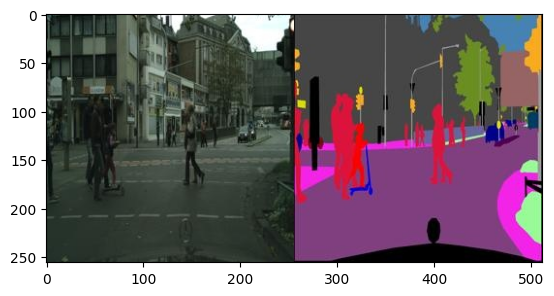

In [5]:
sample_image_fp = os.path.join(os.path.join('cityscapes_data', 'train'), '15.jpg')
sample_image = Image.open(sample_image_fp).convert('RGB')
plt.imshow(sample_image)
print(sample_image_fp)

In [6]:
def split_images(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

Sample image shape: (256, 512, 3)


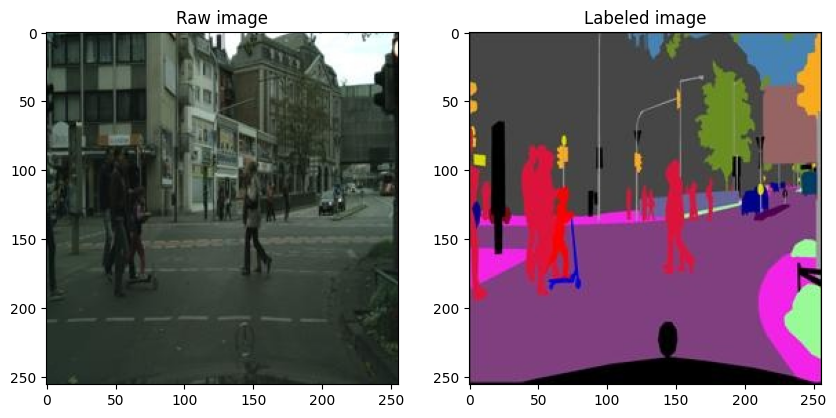

In [7]:
sample_image = np.array(sample_image)
print(f'Sample image shape: {sample_image.shape}')

cityscape, label = split_images(sample_image)
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

axes[0].set_title('Raw image')
axes[1].set_title('Labeled image')

plt.show()

## LABELS

In [8]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[157  21 107]
 [134  77   5]
 [ 73  59  15]
 [ 99 174 195]
 [ 76  10 121]]


In [9]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

label_model.predict(color_array[:5, :])

array([5, 7, 7, 2, 1], dtype=int32)

Label classes: [[7 7 7 ... 7 7 7]
 [7 7 7 ... 0 0 7]
 [7 7 7 ... 6 6 7]
 ...
 [7 1 1 ... 9 9 1]
 [7 7 7 ... 9 1 7]
 [7 7 7 ... 7 7 7]]


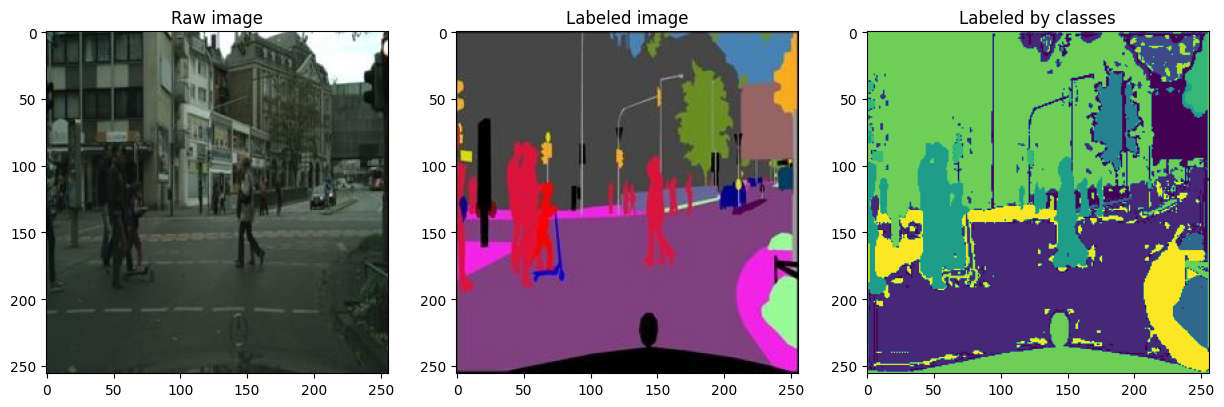

In [10]:
cityscape, label = split_images(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

axes[0].set_title('Raw image')
axes[1].set_title('Labeled image')
axes[2].set_title('Labeled by classes')

print(f'Label classes: {label_class}')

plt.show()

## Define dataset for further analysis

In [11]:
class CityDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_fns[idx])).convert('RGB')
        image = np.array(image)

        cityscape, label = self.split_images(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_images(self, input):
        image = np.array(input)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [12]:
train_data = CityDataset(os.path.join('cityscapes_data', 'train'), label_model)

In [13]:
print(f'Size of train dataset: {len(train_data)}')

Size of train dataset: 2975


In [14]:
cityscape, label_class = train_data[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Define U-Net model

In [16]:
data_loader = DataLoader(train_data, batch_size=4)
print(f'Size of train data: {len(train_data)}, size of DataLoader output: {len(data_loader)}')

print('')

iterable_train_data = iter(data_loader)
X, Y = iterable_train_data.__next__()
print(f'X shape: {X.shape}, Y shape: {Y.shape}')

Size of train data: 2975, size of DataLoader output: 744

X shape: torch.Size([4, 3, 256, 256]), Y shape: torch.Size([4, 256, 256])


### Define DeepLab model

In [17]:
# class DeepLab(nn.Module):
#     def __init__(self, num_classes):
#         super(DeepLab, self).__init__()

#         self.num_classes = num_classes

#         self.conv1 = self.convolution_block(3, 64, 3, 1, 1)
#         self.conv2 = self.convolution_block(64, 128, 3, 1, 1)
#         self.conv3 = self.convolution_block(128, 256, 3, 1, 1)
#         self.conv4 = self.convolution_block(256, 512, 3, 1, 1)
#         self.conv5 = self.convolution_block(512, 512, 3, 1, 1)

#         self.fc1 = nn.Conv2d(512, 256, kernel_size=1)
#         self.fc2 = nn.Conv2d(256, 256, kernel_size=1)
#         self.fc3 = nn.Conv2d(256, num_classes, kernel_size=1)

#     def convolution_block(self, in_channels, out_channels, kernel_size, stride, padding):
#         block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#         return block

#     def forward(self, x):
#         conv1_out = self.conv1(x)
#         conv2_out = self.conv2(conv1_out)
#         conv3_out = self.conv3(conv2_out)
#         conv4_out = self.conv4(conv3_out)
#         conv5_out = self.conv5(conv4_out)

#         fc1_out = self.fc1(conv5_out)
#         fc2_out = self.fc2(fc1_out)
#         fc3_out = self.fc3(fc2_out)

#         output = F.interpolate(fc3_out, size=x.shape[2:], mode='bilinear', align_corners=False)

#         return output

In [18]:
class DeepLab(nn.Module):
    def __init__(self, num_classes):
        super(DeepLab, self).__init__()

        self.num_classes = num_classes
        resnet = models.resnet101(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        self.classifier = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1, stride=1)
        )

    def forward(self, x):
        features = self.features(x)
        logits = self.classifier(features)
        logits = nn.functional.interpolate(logits, size=x.size()[2:], mode='bilinear', align_corners=False)
        return logits

In [19]:
deep_lab = DeepLab(num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/nastya/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:38<00:00, 4.61MB/s] 


In [20]:
Y_hat = deep_lab(X)

print(f'Shape of predicted Y: {Y_hat.shape}')

Shape of predicted Y: torch.Size([4, 10, 256, 256])


In [21]:
batch_size = 16

epochs = 10
lr = 0.01

In [22]:
dataset = CityDataset(os.path.join('cityscapes_data', 'train'), label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [23]:
model = DeepLab(num_classes=num_classes).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

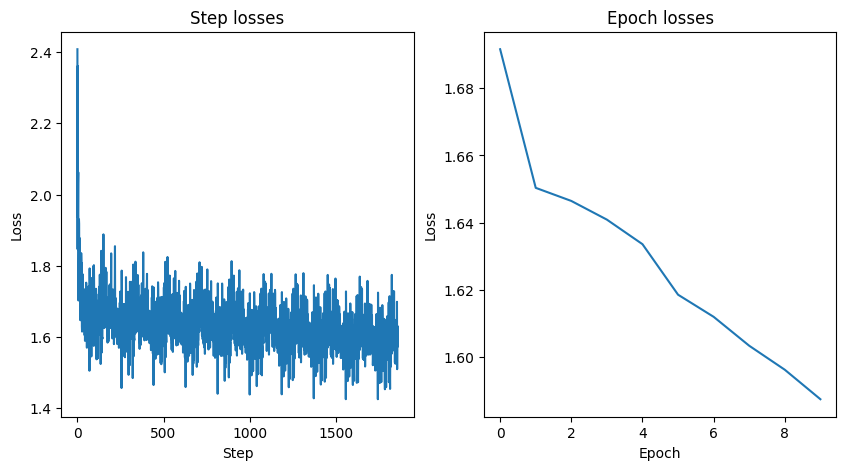

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

axes[0].set_title('Step losses')
axes[1].set_title('Epoch losses')

axes[0].set_xlabel('Step')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Loss')

In [30]:
deeplab_name = "DeepLab.pth"
torch.save(model.state_dict(), deeplab_name)

## Check predictions

In [31]:
deeplab_path = "DeepLab.pth"
deeplab_model_ = DeepLab(num_classes=num_classes).to(device)
deeplab_model_.load_state_dict(torch.load(deeplab_path))

<All keys matched successfully>

In [32]:
test_batch_size = 8
dataset = CityDataset(os.path.join('cityscapes_data', 'val'), label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [33]:
X, Y = iter(data_loader).__next__()
X, Y = X.to(device), Y.to(device)
Y_pred = deeplab_model_(X)
print(f'Raw Y predicted shape: {Y_pred.shape}')
Y_pred = torch.argmax(Y_pred, dim=1)
print(f'Y predicted shape with torch argmax: {Y_pred.shape}')

Raw Y predicted shape: torch.Size([8, 10, 256, 256])
Y predicted shape with torch argmax: torch.Size([8, 256, 256])


In [34]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

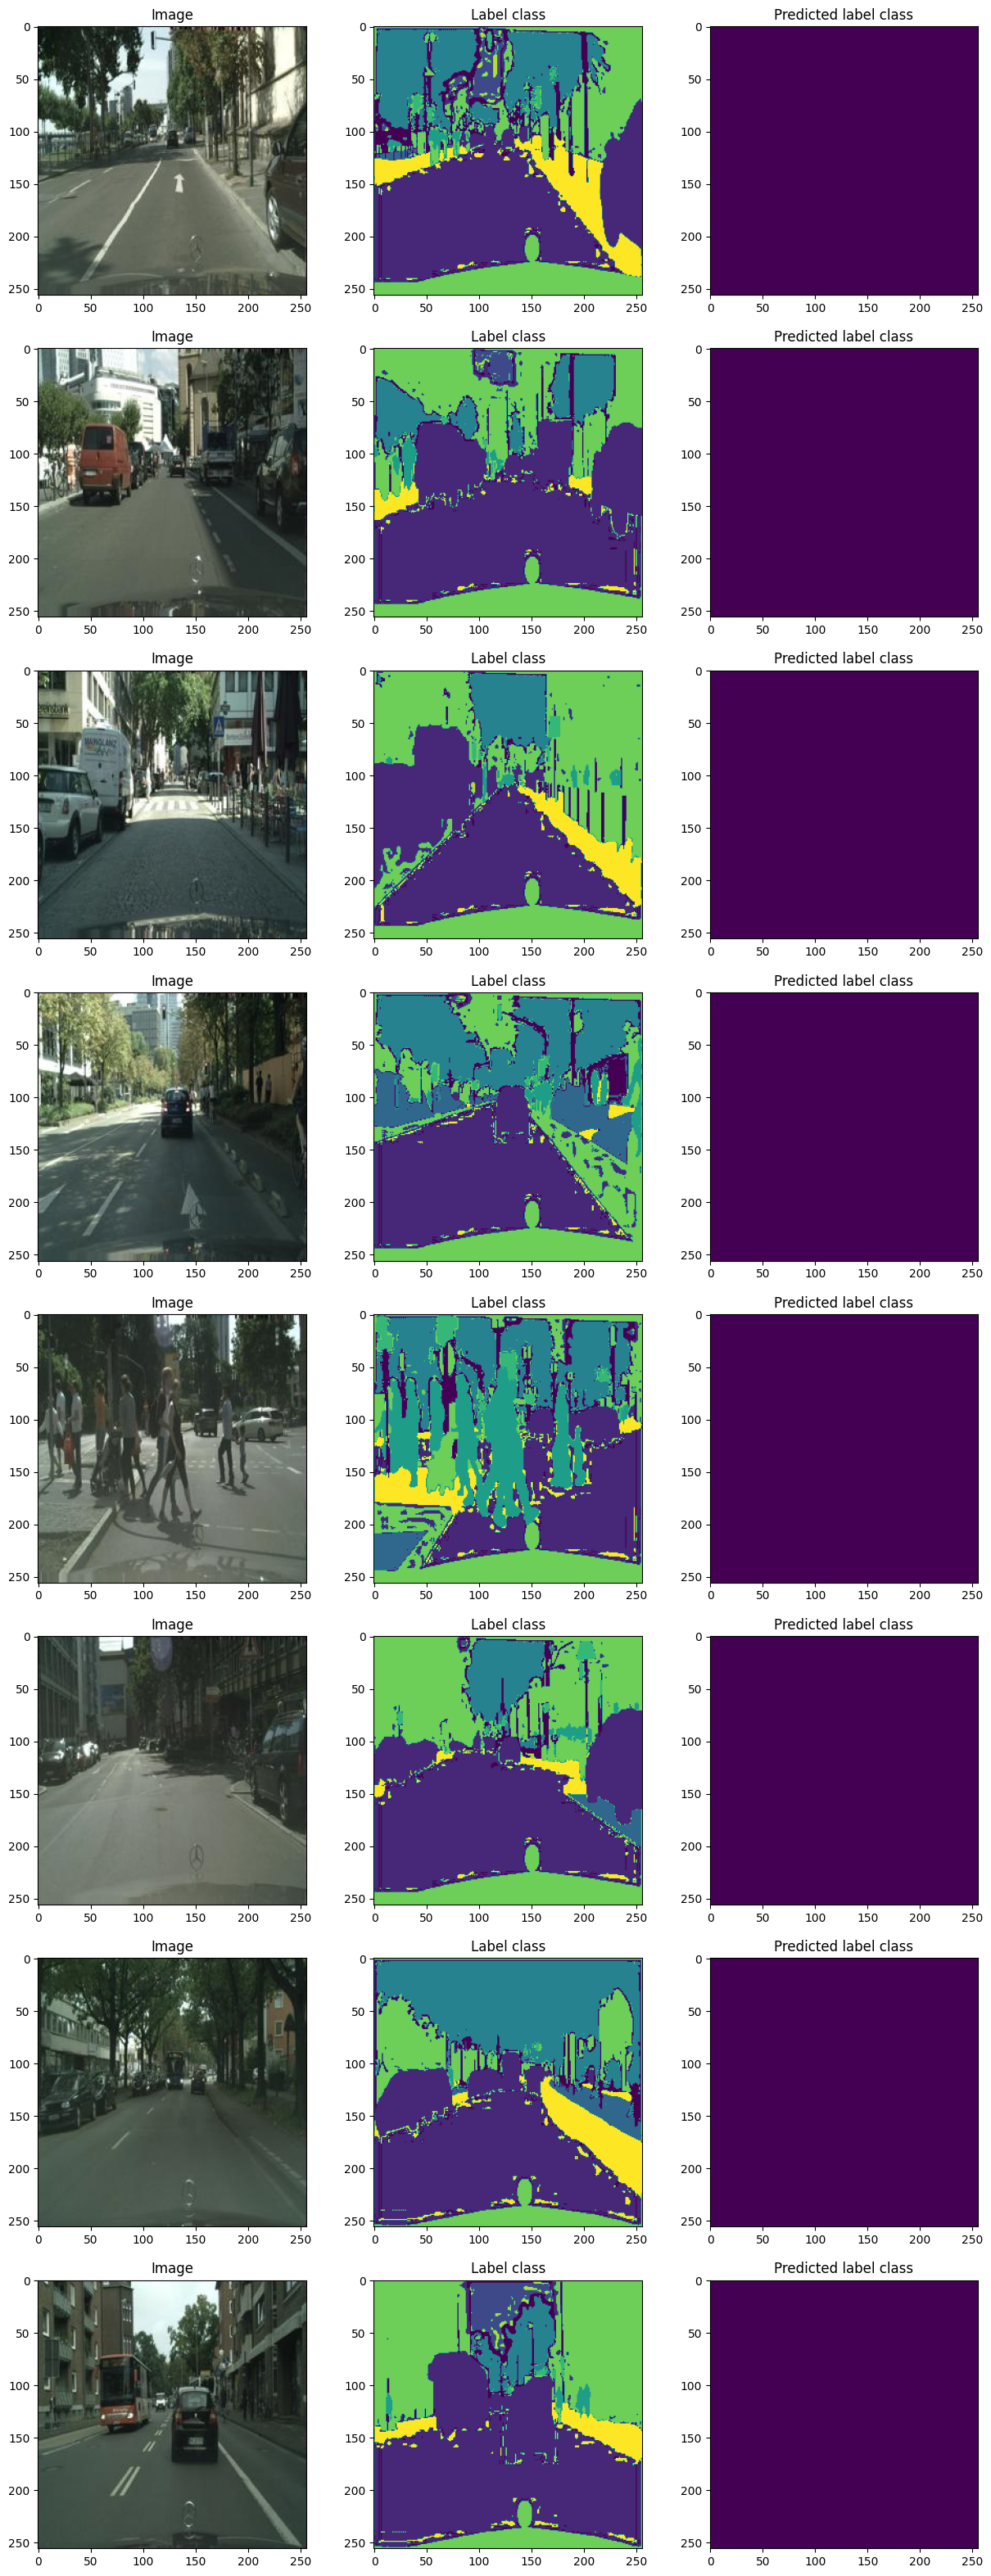

In [35]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Predicted label class")